# Inisialisasi

In [1]:
# !pip install -qq transformers
!pip install -qq scikit-multilearn
!pip install -qq pysastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.5 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
# import nlpaug.augmenter.word as naw
# import torch
# import torch.nn.functional as F
# import torch.nn as nn

# from transformers import AutoTokenizer, AutoModel, get_constant_schedule_with_warmup, BertForPreTraining
# from transformers import TrainingArguments, Trainer, AutoConfig
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
nltk.download('punkt')

import pandas as pd
import xml.etree.ElementTree as ET
import re
import seaborn as sns
import warnings
import string
warnings.filterwarnings("ignore", 'This pattern has match groups')
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
seed_val = 1906350912
random.seed(seed_val)
np.random.seed(seed_val)

In [4]:

categories = ['Anak', 'Bedah', 'Gigi', 'Gizi', 'Jantung', 'Jiwa',
       'Kandungan', 'Kulit dan Kelamin', 'Mata', 'Paru', 'Penyakit Dalam',
       'Saraf', 'THT', 'Tulang', 'Urologi']


categories_umum = ['Anak', 'Bedah', 'Gigi', 'Gizi', 'Jantung', 'Jiwa',
       'Kandungan', 'Kulit dan Kelamin', 'Mata', 'Paru', 'Penyakit Dalam',
       'Saraf', 'THT', 'Tulang', 'Urologi', 'Umum']


In [5]:
df_train = pd.read_csv(f"Dataset/Train.csv").drop(columns=['Unnamed: 0'])
df_train.fillna("", inplace = True)
df_train['All'] = df_train['JUDUL'] + ' <SEP> ' + df_train['ISI']
df_train = df_train.drop(columns=['JUDUL', 'ISI'])

df_pred = pd.read_csv(f"Dataset/Pred.csv").drop(columns=['Unnamed: 0'])
df_pred.fillna("", inplace = True)
df_pred['All'] = df_pred['JUDUL'] + ' <SEP> ' + df_pred['ISI']
df_pred = df_pred.drop(columns=['JUDUL', 'ISI'])

df_test = pd.read_csv(f"Dataset/Gold_Standard.csv", index_col="ID")
df_test.fillna("", inplace = True)
df_test['Count'] = df_test.drop(columns=['JUDUL', 'ISI']).values.sum(axis=1)
df_test = df_test[df_test['Count'] <= 3].drop(columns=['Count'])
df_test = df_test[["JUDUL", "ISI"] + categories_umum]

df_test_umumnt = df_test.drop(columns=["Umum"])
df_test_umumnt["COUNT CLASS"] = df_test_umumnt.drop(columns=["JUDUL", "ISI"]).sum(axis=1)
df_test = df_test_umumnt[df_test_umumnt["COUNT CLASS"] > 0].drop(columns=["COUNT CLASS"])
del df_test_umumnt

df_test["All"] = df_test['JUDUL'] + " " + df_test['ISI']
df_test = df_test.drop(columns=['JUDUL', 'ISI'])
df_test = df_test[['All'] + categories]

categories = ['Anak', 'Bedah', 'Gigi', 'Gizi', 'Jantung', 'Jiwa',
       'Kandungan', 'Kulit dan Kelamin', 'Mata', 'Paru', 'Penyakit Dalam',
       'Saraf', 'THT', 'Tulang', 'Urologi']


In [6]:
y_pred = df_pred.drop(columns=['All']).values
y_test = df_test.drop(columns=['All']).values

# Fungsi

In [7]:
def get_pred_gold(df_pred, col, gold):
  df_pred = df_pred[["All"] + [col]]
  df_pred = df_pred.rename(columns={col: "Pred"})
  idx = categories.index(col)
  return pd.concat([df_pred, pd.DataFrame(gold[:,idx], columns=['Gold'])], axis=1)[['All', 'Gold', 'Pred']]

In [8]:
from nltk.parse.transitionparser import remove
from collections import defaultdict

def lower_text(texts):
    return [s.lower() for s in texts]

def remove_punc_text(texts):
    return [s.translate(str.maketrans("","",string.punctuation + "1234567890")) for s in texts]

def strip_text(texts):
    return [s.strip() for s in texts]

def remove_stopword_text(texts):
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    stopwords.remove('mata')
    stopwords.remove('ingat')
    stopwords.remove('orang')
    ext_stopwords = ['dok', 'doc', 'dokter', 'terima', 'kasih', 'terimakasih', 'sep']
    all_stopwords = stopwords + ext_stopwords
    dictionary = ArrayDictionary(all_stopwords)
    stopword = StopWordRemover(dictionary)
    return [stopword.remove(s) for s in texts]

def stemming_text(texts):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(s) for s in texts]

def tokenize_text(texts):
    return [word_tokenize(s) for s in texts]

def cleaning_text(texts):
    texts = lower_text(texts)
    texts = remove_punc_text(texts)
    texts = strip_text(texts)
    texts = remove_stopword_text(texts)
    texts = stemming_text(texts)
    return texts

def get_top_k_occurrences(strings, k):
    word_occurrences = get_word_occurrences(strings)
    sorted_occurrences = sorted(word_occurrences.items(), key=lambda item: item[1], reverse=True)
    top_k = sorted_occurrences[:k]
    keywords = [item[0] if type(item[0]) != tuple else ' '.join(item[0]) for item in top_k]
    return top_k, keywords

def get_word_occurrences(strings):
    word_occurrences = defaultdict(int)
    for string in strings:
        words = string.split()
        # Count unigrams
        for word in words:
            word_occurrences[word] += 1
        # Count bigrams
        bigrams = zip(words[:-1], words[1:])
        for bigram in bigrams:
            word_occurrences[bigram] += 1
    word_occurrences = dict(sorted(word_occurrences.items(), key=lambda item: item[1], reverse=True))
    return word_occurrences

In [9]:
def find_kw_occur(text, kw):
  total = 0
  kw_found = []
  temp = []
  for i in kw:
    if i in text:
      kw_found.append(i)
  filtered = filter_ngram(kw_found)

  for i in filtered:
    if i in text:
      total += 1
  return total, filtered

def is_in(kw, text):
  if (len(kw.split()) == 1):
    kw = " " + kw + " "
    text = " " + text + " "
  return kw in text

def filter_kw(text, kw):
  text_kw = []
  for i in kw:
    for j in text:
      if is_in(i, j):
        text_kw.append(i)
        break
  return text_kw

def count_kw_occurences(text, kw):
  kw_dict = dict()
  for i in kw:
    count = 0
    for j in text:
      if i in j:
        count += 1
    kw_dict[i] = count
  return kw_dict

def filter_ngram(lst):
  group1 = [s for s in lst if len(s.split()) == 1]
  group2 = [s for s in lst if len(s.split()) == 2]
  group3 = [s for s in lst if len(s.split()) == 3]

  unigram = []
  for i in group1:
      if not any(i in ngram for ngram in (group3 + group2)):
          unigram.append(i)

  bigram = []
  for i in group2:
      if not any(i in ngram for ngram in group3):
          bigram.append(i)

  return group3 + bigram + unigram

In [10]:
def get_fn(df):
  df = df[df['Gold'] == 1]
  df = df[df['Pred'] == 0]
  return df

def get_tp(df):
  df = df[df['Gold'] == 1]
  df = df[df['Pred'] == 1]
  return df

In [11]:
from functools import reduce
def summarize_plot(col, kw):
  df_comp = get_pred_gold(df_pred, col, y_test)
  print("Contingency Table")
  display(pd.crosstab(df_comp['Gold'], df_comp['Pred']))
  print()
  fn = get_fn(df_comp)
  tp = get_tp(df_comp)
  train = df_train[df_train[col] == 1]['All'].values
  clean_train = cleaning_text(train)
  train_kw = filter_kw(clean_train, kw)
  print("Keyword yang muncul pada data training")
  print(train_kw)
  print()
  clean_fn = cleaning_text(fn['All'].values)
  clean_tp = cleaning_text(tp['All'].values)
  kw_in_fn = [find_kw_occur(i, train_kw) for i in clean_fn]
  kw_in_tp = [find_kw_occur(i, train_kw) for i in clean_tp]
  kw_in_train = [find_kw_occur(i, train_kw) for i in clean_train]
  print("Keyword yg muncul pada FN")
  if (len(fn) > 10):
    print(f"FN ada {len(fn)}, maka hanya ditampilkan 10 teratas saja")
  print(kw_in_fn[:10])
  print()
  print("Keyword yg muncul pada TP")
  if (len(tp) > 10):
    print(f"TP ada {len(tp)}, maka hanya ditampilkan 10 teratas saja")
  print(kw_in_tp[:10])
  print()
  found_kw = [i[1] for i in kw_in_fn]
  used_kw = list(reduce(lambda x, y: set(x) | set(y), found_kw))

  fig, axes = plt.subplots(1, 2, figsize=(7, 5))

  # Plot for the first subplot
  counter1 = Counter([i[0] for i in kw_in_train])
  data1 = pd.DataFrame({'Category': counter1.keys(), 'Value': counter1.values()})
  ax1 = sns.barplot(x='Category', y='Value', data=data1, palette="Blues", ax=axes[0])
  ax1.bar_label(ax1.containers[0])
  ax1.set_ylim([0, data1['Value'].max() * 1.1])
  ax1.set(xlabel=None, ylabel=None)
  ax1.set_title('Data Latih')
  ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  # Plot for the second subplot
  counter2 = Counter([i[0] for i in kw_in_fn])
  data2 = pd.DataFrame({'Category': counter2.keys(), 'Value': counter2.values()})
  ax2 = sns.barplot(x='Category', y='Value', data=data2, palette="Blues", ax=axes[1])
  ax2.bar_label(ax2.containers[0])
  ax2.set_ylim([0, data2['Value'].max() * 1.1])
  ax2.set(xlabel=None, ylabel=None)
  ax2.set_title('Data False Negative')
  ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

  # Set shared xlabel and ylabel
  fig.text(0.5, 0, 'Jumlah keyword yang muncul', ha='center')
  fig.text(0.03, 0.5, 'Banyak instance', va='center', rotation='vertical')
  fig.suptitle(f"Kelas {col}", y = 1)

  plt.tight_layout()
  plt.show()

# Metrik

In [12]:
from sklearn.metrics import classification_report, accuracy_score, jaccard_score, hamming_loss, cohen_kappa_score
import math
print("================ Classification Report ================")
print(classification_report(df_test.drop(columns=['All']).values, df_pred.drop(columns=['All']).values, target_names=categories, digits=4))

================ Classification Report ================
                   precision    recall  f1-score   support

             Anak     0.9762    0.9535    0.9647        43
            Bedah     0.8182    0.9310    0.8710        29
             Gigi     1.0000    1.0000    1.0000        42
             Gizi     0.9767    0.9767    0.9767        43
          Jantung     0.8000    0.4000    0.5333        10
             Jiwa     0.9286    0.9070    0.9176        43
        Kandungan     0.9333    0.9767    0.9545        43
Kulit dan Kelamin     0.9773    0.9348    0.9556        46
             Mata     1.0000    1.0000    1.0000        26
             Paru     1.0000    1.0000    1.0000         2
   Penyakit Dalam     0.7115    0.8810    0.7872        42
            Saraf     0.9091    0.7143    0.8000        14
              THT     0.8269    1.0000    0.9053        43
           Tulang     0.9211    1.0000    0.9589        35
          Urologi     0.8462    0.7857    0.8148        14

Contingency Table


Pred,0,1
Gold,,
0,458,1
1,6,4



Keyword yang muncul pada data training
['dada', 'nafas', 'sesak', 'panik', 'jantung', 'ekg', 'detak', 'berdebarberdebar', 'obatobat', 'bisoprolol', 'panic', 'hipertiroid', 'aritmia', 'dada tengah', 'dada belah', 'akibat jantung', 'dosis mghari', 'tinggi keluh', 'rekam jantung', 'nyaman dada', 'jantung akibat', 'turun tekan']

Keyword yg muncul pada FN
[(1, ['dada belah']), (3, ['nafas', 'sesak', 'jantung']), (2, ['dada', 'sesak']), (2, ['dada', 'jantung']), (1, ['jantung']), (1, ['jantung'])]

Keyword yg muncul pada TP
[(4, ['dada', 'jantung', 'detak', 'aritmia']), (2, ['dada', 'nafas']), (3, ['dada', 'sesak', 'jantung']), (2, ['dada', 'jantung'])]



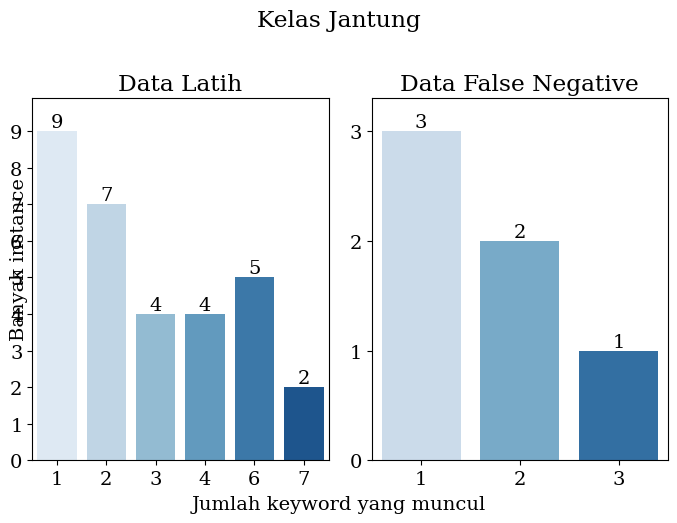

<Figure size 640x480 with 0 Axes>

In [13]:
#@title Jantung
col = "Jantung" #@param {type:"string"}
kw = ['dada', 'nafas', 'sesak', 'panik', 'jantung', 'ekg', 'detak', 'berdebarberdebar', 'obatobat', 'bisoprolol', 'panic', 'hipertiroid', 'aritmia', 'dada tengah', 'dada belah', 'akibat jantung', 'dosis mghari', 'tinggi keluh', 'rekam jantung', 'nyaman dada', 'jantung akibat', 'turun tekan', 'tinggi keluh sakit'] #@param {type:"raw"}
summarize_plot(col, kw)

Contingency Table


Pred,0,1
Gold,,
0,454,1
1,4,10



Keyword yang muncul pada data training
['otak', 'pinggang', 'kepala', 'leher', 'syaraf', 'stroke', 'bentur kepala', 'cedera kepala', 'akibat bentur', 'sakit tulang punggung']

Keyword yg muncul pada FN
[(1, ['kepala']), (0, []), (1, ['stroke']), (0, [])]

Keyword yg muncul pada TP
[(0, []), (1, ['akibat bentur']), (2, ['kepala', 'stroke']), (3, ['bentur kepala', 'cedera kepala', 'otak']), (1, ['stroke']), (0, []), (1, ['kepala']), (2, ['otak', 'stroke']), (1, ['kepala']), (1, ['kepala'])]



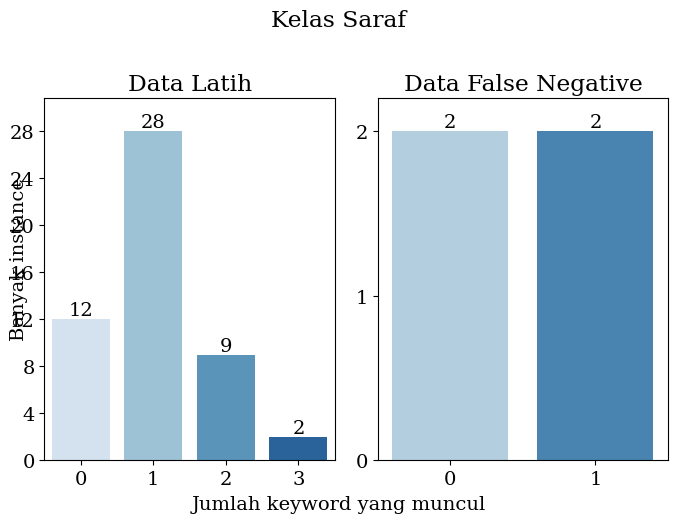

<Figure size 640x480 with 0 Axes>

In [14]:
#@title Saraf
col = "Saraf" #@param {type:"string"}
kw = ['otak', 'pinggang', 'kepala', 'leher', 'syaraf', 'stroke', 'bentur kepala', 'cedera kepala', 'akibat bentur', 'sakit tulang punggung'] #@param {type:"raw"}
summarize_plot(col, kw)

Contingency Table


Pred,0,1
Gold,,
0,453,2
1,3,11



Keyword yang muncul pada data training
['tumor', 'ginjal', 'bak', 'kemih', 'urin', 'kencing', 'bedah', 'batu', 'urologi', 'testis', 'prostat', 'kateter', 'beser', 'selang ginjal', 'usg ginjal', 'bedah urologi', 'pasang selang', 'retensi urin', 'ginjal operasi', 'operasi batu ginjal', 'batu ginjal operasi']

Keyword yg muncul pada FN
[(0, []), (0, []), (0, [])]

Keyword yg muncul pada TP
TP ada 11, maka hanya ditampilkan 10 teratas saja
[(0, []), (3, ['ginjal', 'kemih', 'batu']), (2, ['ginjal', 'batu']), (4, ['ginjal', 'kemih', 'batu', 'testis']), (2, ['tumor', 'kemih']), (3, ['ginjal', 'kemih', 'kencing']), (4, ['ginjal', 'kemih', 'batu', 'urologi']), (0, []), (5, ['bedah urologi', 'ginjal', 'kemih', 'urin', 'batu']), (3, ['bak', 'kencing', 'beser'])]



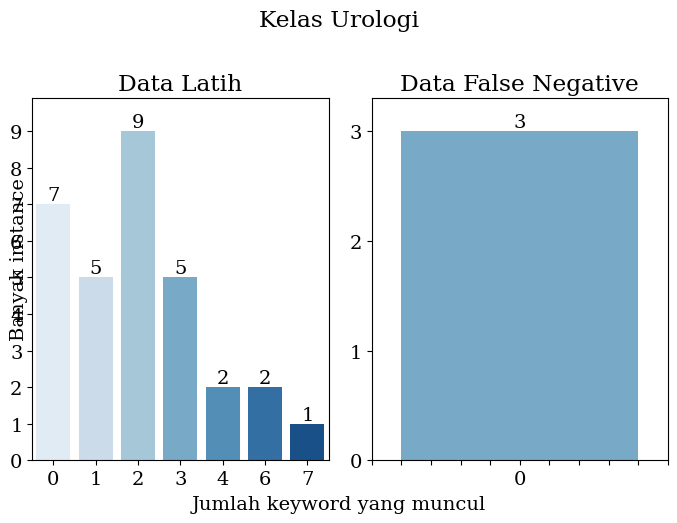

<Figure size 640x480 with 0 Axes>

In [15]:
#@title Urologi
col = "Urologi" #@param {type:"string"}
kw = ['tumor', 'ginjal', 'bak', 'kemih', 'urin', 'kencing', 'bedah', 'batu', 'urologi', 'testis', 'prostat', 'kateter', 'beser', 'selang ginjal', 'usg ginjal', 'bedah urologi', 'pasang selang', 'retensi urin', 'ginjal operasi', 'operasi batu ginjal', 'batu ginjal operasi'] #@param {type:"raw"}
summarize_plot(col, kw)

Contingency Table


Pred,0,1
Gold,,
0,412,15
1,5,37



Keyword yang muncul pada data training
['darah', 'perut', 'usus', 'bab', 'punggung', 'dada', 'lambung', 'mual', 'hati', 'sesak', 'jantung', 'ginjal', 'maag', 'diabetes', 'stroke', 'usus buntu', 'gejala sakit', 'sakit ulu', 'ulu hati', 'hati sakit', 'nyeri ulu', 'sakit ulu hati', 'ulu hati sakit', 'nyeri ulu hati']

Keyword yg muncul pada FN
[(1, ['ginjal']), (2, ['darah', 'bab']), (0, []), (1, ['diabetes']), (1, ['ginjal'])]

Keyword yg muncul pada TP
TP ada 37, maka hanya ditampilkan 10 teratas saja
[(4, ['darah', 'ginjal', 'diabetes', 'stroke']), (0, []), (2, ['lambung', 'jantung']), (3, ['nyeri ulu hati', 'dada', 'lambung']), (1, ['perut']), (2, ['darah', 'perut']), (8, ['nyeri ulu hati', 'perut', 'bab', 'dada', 'mual', 'sesak', 'jantung', 'maag']), (2, ['darah', 'hati']), (0, []), (0, [])]



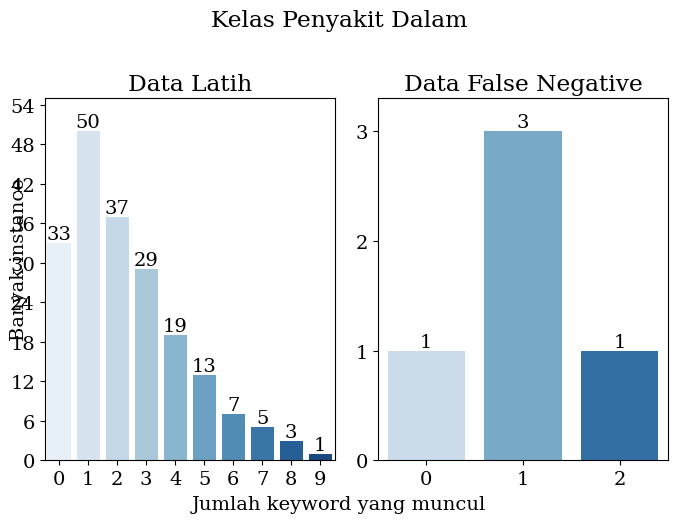

<Figure size 640x480 with 0 Axes>

In [16]:
#@title Penyakit Dalam
col = "Penyakit Dalam" #@param {type:"string"}
kw = ['darah', 'perut', 'usus', 'bab', 'punggung', 'dada', 'lambung', 'mual', 'hati', 'sesak', 'jantung', 'ginjal', 'maag', 'diabetes', 'stroke', 'usus buntu', 'gejala sakit', 'sakit ulu', 'ulu hati', 'hati sakit', 'nyeri ulu', 'sakit ulu hati', 'ulu hati sakit', 'nyeri ulu hati'] #@param {type:"raw"}
summarize_plot(col, kw)

# Metrik

In [17]:
from sklearn.metrics import classification_report, accuracy_score, jaccard_score, hamming_loss, cohen_kappa_score
import math
print("================ Classification Report ================")
print(classification_report(df_test.drop(columns=['All']).values, df_pred.drop(columns=['All']).values, target_names=categories, digits=4))

================ Classification Report ================
                   precision    recall  f1-score   support

             Anak     0.9762    0.9535    0.9647        43
            Bedah     0.8182    0.9310    0.8710        29
             Gigi     1.0000    1.0000    1.0000        42
             Gizi     0.9767    0.9767    0.9767        43
          Jantung     0.8000    0.4000    0.5333        10
             Jiwa     0.9286    0.9070    0.9176        43
        Kandungan     0.9333    0.9767    0.9545        43
Kulit dan Kelamin     0.9773    0.9348    0.9556        46
             Mata     1.0000    1.0000    1.0000        26
             Paru     1.0000    1.0000    1.0000         2
   Penyakit Dalam     0.7115    0.8810    0.7872        42
            Saraf     0.9091    0.7143    0.8000        14
              THT     0.8269    1.0000    0.9053        43
           Tulang     0.9211    1.0000    0.9589        35
          Urologi     0.8462    0.7857    0.8148        14

Contingency Table


Pred,0,1
Gold,,
0,458,1
1,6,4



Keyword yang muncul pada data training
['dada', 'nafas', 'sesak', 'tekan', 'panik', 'jantung', 'debar', 'denyut', 'capai', 'kencang', 'ekg', 'ulang', 'detak', 'dosis', 'berdebarberdebar', 'obatobat', 'bisoprolol', 'panic', 'hipertiroid', 'mghari', 'rekam', 'mmhg', 'aritmia', 'dada tengah', 'dada belah', 'akibat jantung', 'dosis mghari', 'tinggi keluh', 'rekam jantung', 'nyaman dada', 'jantung akibat', 'turun tekan']

Keyword yg muncul pada FN
[(1, ['dada belah']), (5, ['nafas', 'sesak', 'jantung', 'debar', 'kencang']), (3, ['dada', 'sesak', 'capai']), (2, ['dada', 'jantung']), (3, ['jantung', 'debar', 'kencang']), (1, ['jantung'])]

Keyword yg muncul pada TP
[(6, ['dada', 'jantung', 'debar', 'denyut', 'detak', 'aritmia']), (2, ['dada', 'nafas']), (4, ['dada', 'sesak', 'jantung', 'denyut']), (2, ['dada', 'jantung'])]



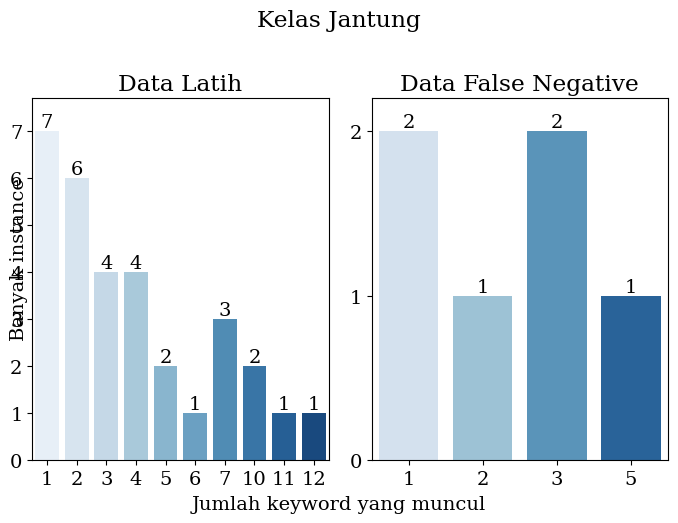

<Figure size 640x480 with 0 Axes>

In [18]:
#@title Jantung
col = "Jantung" #@param {type:"string"}
kw = ['dada', 'nafas', 'sesak', 'tekan', 'panik', 'jantung', 'debar', 'denyut', 'capai', 'kencang', 'ekg', 'ulang', 'detak', 'dosis', 'berdebarberdebar', 'obatobat', 'bisoprolol', 'panic', 'hipertiroid', 'mghari', 'rekam', 'mmhg', 'aritmia', 'dada tengah', 'dada belah', 'akibat jantung', 'dosis mghari', 'tinggi keluh', 'rekam jantung', 'nyaman dada', 'jantung akibat', 'turun tekan', 'tinggi keluh sakit'] #@param {type:"raw"}
summarize_plot(col, kw)

Contingency Table


Pred,0,1
Gold,,
0,454,1
1,4,10



Keyword yang muncul pada data training
['otak', 'duduk', 'pinggang', 'kepala', 'leher', 'motor', 'celaka', 'jatuh', 'sepeda', 'syaraf', 'beliau', 'ekor', 'cedera', 'stroke', 'bentur kepala', 'cedera kepala', 'akibat bentur', 'sakit tulang punggung']

Keyword yg muncul pada FN
[(1, ['kepala']), (0, []), (1, ['stroke']), (0, [])]

Keyword yg muncul pada TP
[(1, ['cedera']), (3, ['akibat bentur', 'celaka', 'jatuh']), (2, ['kepala', 'stroke']), (3, ['bentur kepala', 'cedera kepala', 'otak']), (1, ['stroke']), (1, ['motor']), (1, ['kepala']), (2, ['otak', 'stroke']), (1, ['kepala']), (1, ['kepala'])]



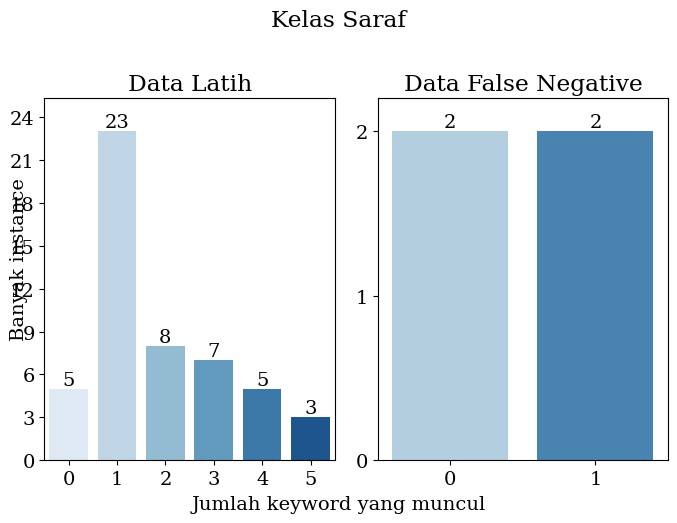

<Figure size 640x480 with 0 Axes>

In [19]:
#@title Saraf
col = "Saraf" #@param {type:"string"}
kw = ['otak', 'duduk', 'pinggang', 'kepala', 'leher', 'motor', 'celaka', 'jatuh', 'sepeda', 'syaraf', 'beliau', 'ekor', 'cedera', 'stroke', 'bentur kepala', 'cedera kepala', 'akibat bentur', 'sakit tulang punggung'] #@param {type:"raw"}
summarize_plot(col, kw)

Contingency Table


Pred,0,1
Gold,,
0,453,2
1,3,11



Keyword yang muncul pada data training
['tumor', 'ginjal', 'bak', 'kemih', 'urin', 'lambat', 'sinar', 'kencing', 'bedah', 'gugur', 'batu', 'ml', 'selang', 'pasang', 'urologi', 'testis', 'prostat', 'kateter', 'laser', 'beser', 'flow', 'selang ginjal', 'usg ginjal', 'bedah urologi', 'pasang selang', 'retensi urin', 'ginjal operasi', 'operasi batu ginjal', 'batu ginjal operasi']

Keyword yg muncul pada FN
[(0, []), (0, []), (0, [])]

Keyword yg muncul pada TP
TP ada 11, maka hanya ditampilkan 10 teratas saja
[(0, []), (4, ['ginjal', 'kemih', 'batu', 'laser']), (2, ['ginjal', 'batu']), (4, ['ginjal', 'kemih', 'batu', 'testis']), (2, ['tumor', 'kemih']), (3, ['ginjal', 'kemih', 'kencing']), (4, ['ginjal', 'kemih', 'batu', 'urologi']), (0, []), (5, ['bedah urologi', 'ginjal', 'kemih', 'urin', 'batu']), (4, ['bak', 'kencing', 'ml', 'beser'])]



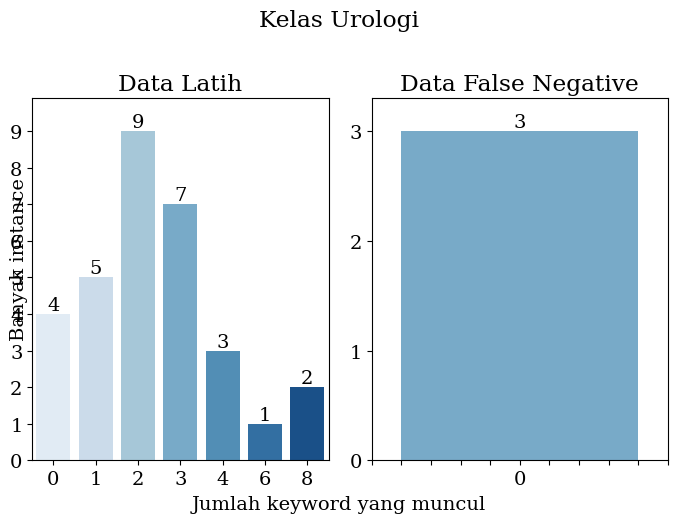

<Figure size 640x480 with 0 Axes>

In [20]:
#@title Urologi
col = "Urologi" #@param {type:"string"}
kw = ['tumor', 'ginjal', 'bak', 'kemih', 'urin', 'lambat', 'sinar', 'kencing', 'bedah', 'gugur', 'batu', 'ml', 'selang', 'pasang', 'donor', 'urologi', 'testis', 'prostat', 'kateter', 'polip', 'laser', 'beser', 'flow', 'selang ginjal', 'usg ginjal', 'bedah urologi', 'pasang selang', 'retensi urin', 'ginjal operasi', 'operasi batu ginjal', 'batu ginjal operasi'] #@param {type:"raw"}
summarize_plot(col, kw)

Contingency Table


Pred,0,1
Gold,,
0,412,15
1,5,37



Keyword yang muncul pada data training
['selamat', 'malam', 'siang', 'gejala', 'darah', 'sakit', 'nyeri', 'perut', 'kanan', 'usus', 'kembung', 'jalan', 'pagi', 'alami', 'periksa', 'derita', 'bab', 'turun', 'kiri', 'kadang', 'keluh', 'panas', 'punggung', 'kambuh', 'kemarin', 'habis', 'obat', 'dada', 'bangun', 'tidur', 'susah', 'nafas', 'makan', 'kepala', 'minum', 'air', 'asam', 'lambung', 'kaki', 'hasil', 'mual', 'demam', 'pusing', 'kirakira', 'ulu', 'hati', 'konsumsi', 'sesak', 'tekan', 'jantung', 'debar', 'leher', 'ginjal', 'maag', 'cek', 'tubuh', 'belah', 'tinggi', 'lemas', 'muntah', 'diabetes', 'stroke', 'usus buntu', 'gejala sakit', 'sakit ulu', 'ulu hati', 'hati sakit', 'nyeri ulu', 'sakit ulu hati', 'ulu hati sakit', 'nyeri ulu hati']

Keyword yg muncul pada FN
[(1, ['ginjal']), (15, ['selamat', 'malam', 'siang', 'gejala', 'darah', 'sakit', 'bab', 'panas', 'kemarin', 'habis', 'makan', 'minum', 'air', 'hasil', 'konsumsi']), (5, ['selamat', 'malam', 'jalan', 'pagi', 'derita']), (6

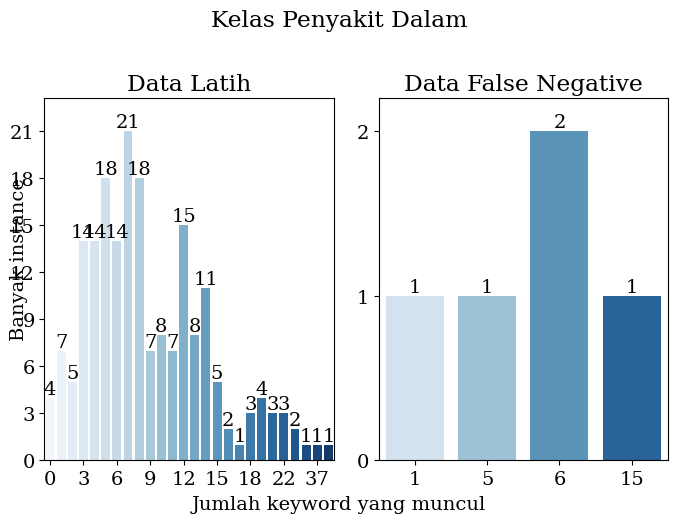

<Figure size 640x480 with 0 Axes>

In [21]:
#@title Penyakit Dalam
col = "Penyakit Dalam" #@param {type:"string"}
kw = ['selamat', 'malam', 'siang', 'gejala', 'darah', 'sakit', 'nyeri', 'perut', 'kanan', 'usus', 'kembung', 'jalan', 'pagi', 'alami', 'periksa', 'derita', 'bab', 'turun', 'kiri', 'kadang', 'keluh', 'panas', 'punggung', 'kambuh', 'kemarin', 'habis', 'obat', 'dada', 'bangun', 'tidur', 'susah', 'nafas', 'makan', 'kepala', 'minum', 'air', 'asam', 'lambung', 'kaki', 'hasil', 'mual', 'demam', 'pusing', 'kirakira', 'ulu', 'hati', 'konsumsi', 'sesak', 'tekan', 'jantung', 'debar', 'leher', 'ginjal', 'maag', 'cek', 'tubuh', 'belah', 'tinggi', 'lemas', 'muntah', 'diabetes', 'stroke', 'usus buntu', 'gejala sakit', 'sakit ulu', 'ulu hati', 'hati sakit', 'nyeri ulu', 'sakit ulu hati', 'ulu hati sakit', 'nyeri ulu hati'] #@param {type:"raw"}
summarize_plot(col, kw)